Unique Camera Callibration For Camera-Lidar Sensor Fusion

Goal

To unwarp the picture so that the camera matches up with the lidar points

![title](goal.png)

![title](lipoints.png)

Problem

Standard methods of image calibration (for example https://wiki.ros.org/image_proc) do not work well with our camera (https://reolink.com/us/product/reolink-duo-poe/)

![title](download.jpg)

Import necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [2]:
buffer = 0
mimg = cv2.imread('mimage.png')
width = mimg.shape[1]
limg = cv2.imread('limage.png')[:, :width//2 + buffer]
rimg = cv2.imread('rimage.png')[:, width//2 - buffer:]

Defines function to display image

In [3]:
def disp(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [4]:
def getCorners(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(gimg, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    return corners

Defines function to display corners

In [5]:
def displayCorners(img, corners, nums=True):
    img = img.copy()
    for i in range(len(corners)):
        point = corners[i]
        cv2.circle(img,(int(point[0][0]),int(point[0][1])),3,(0,0,255),-1)
        if nums:
            cv2.putText(img,str(i),(int(point[0][0]),int(point[0][1])-2),0,0.5,(0,0,255))
    return img

Get left camera picture of calibration board

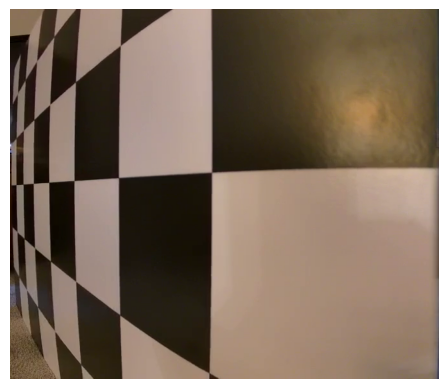

In [6]:
limg = cv2.imread('limage.png')[:, :width//2 + buffer]
disp(limg)

Find potential corners

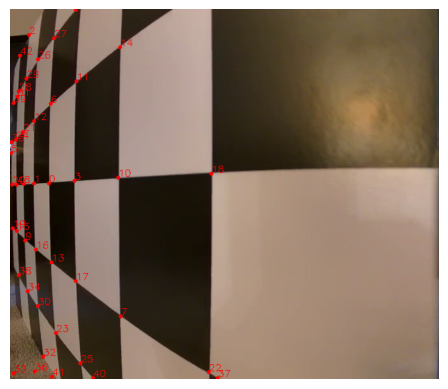

In [23]:
corn = getCorners(limg)
limg_c = displayCorners(limg, corn)
disp(limg_c)

Manually remove incorrect corners

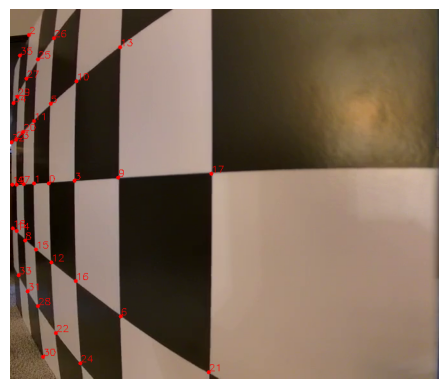

In [24]:
remove = [37, 33, 36, 40, 5, 28, 41,43]

mask = [True]*len(corn)
for r in remove:
    mask[r] = False
corn_n = corn[mask]

limg_c = displayCorners(limg, corn_n, True)
disp(limg_c)

Lineup the indexes of the actual corners

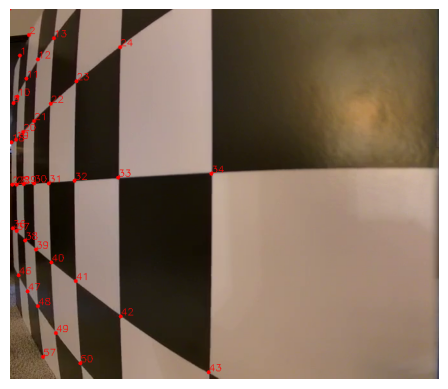

In [25]:
grid_height, grid_width = 7, 9
actual_corners = np.zeros((grid_height*grid_width, 1, 2))-1

map = {35:1, 2:2,
       34:9, 29:10, 27:11, 25:12, 26:13,
       32:18, 23:19, 20:20, 11:21, 5:22, 10:23, 13:24,
       19:27, 4:28, 7:29, 1:30, 0:31, 3:32, 9:33, 17:34,
       18:36, 14:37, 8:38, 15:39, 12:40, 16:41, 6:42, 21:43,
       33:46, 31:47, 28:48, 22:49, 24:50,
       30:57}

assert (sorted(list(map.keys())) == list(range(len(corn_n)))), "map does not map all detected corner points"

for i in range(len(corn_n)):
    actual_corners[map[i]] = corn_n[i]

limg_c = displayCorners(limg, actual_corners, True)
disp(limg_c)

Add Aditional Corners

(576, 668, 3)


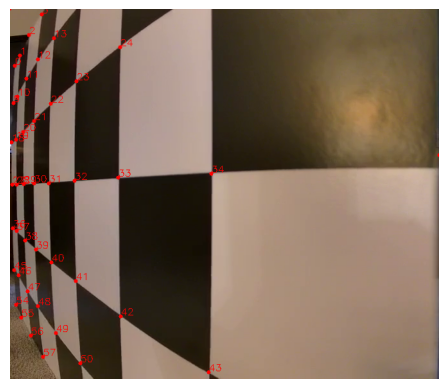

In [26]:
print(limg.shape)
actual_corners[0] = np.array([[7, 88]])
actual_corners[3] = np.array([[49, 8]])
actual_corners[35] = np.array([[668, 227]])
actual_corners[45] = np.array([[6, 406]])
actual_corners[54] = np.array([[9, 460]])
actual_corners[55] = np.array([[17, 480]])
actual_corners[56] = np.array([[32, 508]])

limg_c = displayCorners(limg, actual_corners, True)
disp(limg_c)

Create ideal corner points

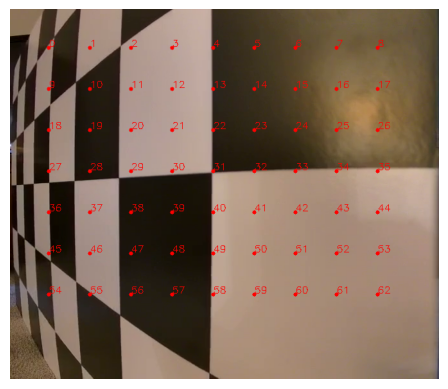

In [11]:
block_len = 64
height, width, _ = limg.shape
ideal_corners = np.zeros((grid_height*grid_width, 1, 2))
start = np.array([60, 60])

for i in range(grid_height):
    for j in range(grid_width):
        ideal_corners[grid_width*i + j, 0] = start
        start[0] += block_len
    start[1] += block_len
    start[0] -= block_len*grid_width

limg_i = displayCorners(limg, ideal_corners)
disp(limg_i)

Define Radial Basis Function

(for an in depth explanation on how RBFs work see: https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-are-radial-basis-functions-neural-networks)

In [12]:
def make_rbf(actual_corners):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(pair.shape)

    rbf_x = RBFInterpolator(pair, actual_corners[filter][:,0,0])
    rbf_y = RBFInterpolator(pair, actual_corners[filter][:,0,1])

    return rbf_x, rbf_y, filter

In [13]:
rbf_x, rbf_y, filter = make_rbf(actual_corners)

(63, 1, 2)
(63, 1, 2)
(43, 2)


Map image according coeficients

In [38]:
def undistort(new_shape):
    old_shape = limg.shape[:2]
    fun_x, fun_y = rbf_x, rbf_y

    x_off = old_shape[0] - new_shape[0]
    y_off = old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return cv2.remap(limg, map_x, map_y, cv2.INTER_LANCZOS4), map_x, map_y

In [39]:
per, map_x, map_y = undistort(limg.shape[:2])

In [59]:
map = np.stack((map_x, map_y), axis=2)
map1, map2 = cv2.convertMaps(map_x, map_y, cv2.CV_16SC2)
print(map1[0,20])

np.save('./calibration_np/left_calibration.npy', map)

[-11  22]


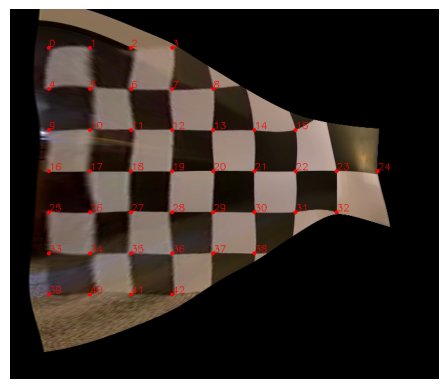

In [60]:
map = np.load('./calibration_np/left_calibration.npy')

per = cv2.remap(limg, map, None, cv2.INTER_CUBIC)
disp(displayCorners(per, ideal_corners[filter]))

(63, 1, 2)
(63, 1, 2)
(43, 2)


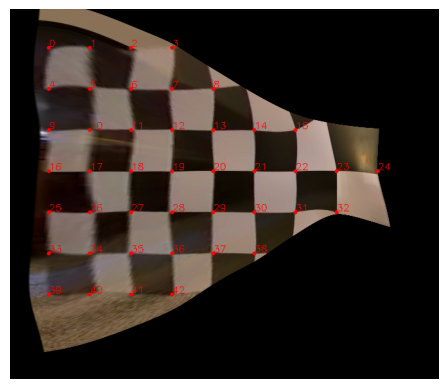

In [37]:
factual_corners = actual_corners.copy()

i=0; factual_corners[i] = actual_corners[i] + [-1, 2]
i=1; factual_corners[i] = actual_corners[i] + [1, -1]

rbf_x, rbf_y, filter = make_rbf(factual_corners)
per, map_x, map_y = undistort(limg.shape[:2])
disp(displayCorners(per, ideal_corners[filter]))

Conclusion

Looks wonky but good enough for minimal viable product

What Still Needs to Get Done For MVP

* Get right side calibration
* Combine callibrations
* Save to npy file

Further Improvents

* Sub-pixel corner detections (https://docs.opencv.org/3.4/dd/d92/tutorial_corner_subpixels.html)
* Iteratively calibrate with lidar (https://arxiv.org/pdf/2303.09825)